# Previsão de Engajamento - Classificação

In [1]:
#@title Importações de pacote
import time

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline

# imports functions that shows the summary results of the model
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, precision_score, make_scorer
from sklearn.base import BaseEstimator, TransformerMixin, clone
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

In [2]:
BASE_PATH = 'dados/'

In [3]:
#@title Definições Auxiliares
class Identity(TransformerMixin, BaseEstimator):
    def __init__(self):
        pass

    def fit(self, X):
        return self

    def transform(self, X):
        return X

    def fit_transform(self, X, y=None):
        return X


# 1 - Carrega os Dados

Carregando dados brutos.

In [4]:
dfx = pd.read_excel(BASE_PATH + 'bolsonaro-preproc2-inputs.xlsx', index_col='ID')
dfx.head()


,Duracao,Dispositivo Retórico_Call to Action,Dispositivo Retórico_Collective Appeal,Dispositivo Retórico_Commitment,Dispositivo Retórico_Endorsement,Dispositivo Retórico_Fact/Statistic,Dispositivo Retórico_Humor,Dispositivo Retórico_Nenhum,Dispositivo Retórico_Opinion,Dispositivo Retórico_Personal Appeal,...,Retórica Aristotélica_Pathos,Tipo de conteúdo_Nenhum,Tipo de conteúdo_Personal,Tipo de conteúdo_Political-Ideological,Tipo de conteúdo_Political-Purposeful,Tonalidade_Neutral,Tonalidade_Positive,Texto / Hashtag_Nenhum,Texto / Hashtag_Texto,Texto / Hashtag_Texto + Hashtag
ID,,,,,,,,,,,,,,,,,,,,,
7114971700365691904,57.93,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,0
7115050482179050496,17.13,0,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0
7115120078982631424,52.54,0,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0
7115161088219565056,34.48,0,0,0,0,0,1,0,0,0,...,0,0,1,0,0,0,1,0,0,0
7115207919750253568,66.66,0,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [46]:
dfy = pd.read_excel(BASE_PATH + 'bolsonaro-preproc2-outputs.xlsx', index_col='ID')
dfy.head()

,Curtidas,Curtidas-Log,Curtidas-4Classes,Curtidas-2Classes
ID,,,,
7114971700365691904,24400,10.102338,medium-low,0
7115050482179050496,9163,9.122929,low,0
7115120078982631424,3485,8.156223,low,0
7115161088219565056,22100,10.003333,medium-low,0
7115207919750253568,115700,11.658756,high,1


In [47]:
#classes_str = ['low', 'medium-low', 'medium-high', 'high']
#dfy = df['Curtidas-4Classes'].apply(lambda x: classes_str.index(x))

classes_str = ['LOW', 'HIGH']
dfy = dfy['Curtidas-2Classes']
dfy.head()

ID
7114971700365691904    0
7115050482179050496    0
7115120078982631424    0
7115161088219565056    0
7115207919750253568    1
Name: Curtidas-2Classes, dtype: int64

# 2 - Seleção do Modelo com Grid Search

Dados que serão usados para a otimização de parâmetros com o *grid search*.

(No momento, estou usando *todos* os dados.)

In [7]:
dfx_grid = dfx
dfy_grid = dfy

## 2.1 - Treinamento simples, sem otimização

In [8]:
model = LogisticRegression()
model.fit(dfx_grid, dfy_grid)

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [9]:
y_predicted = model.predict(dfx_grid)

In [10]:
accuracy_score(dfy_grid, y_predicted)

0.8237547892720306

In [11]:
f1_score(dfy_grid, y_predicted, average='macro')

0.6672394678492239

In [12]:
f1_score(dfy_grid, y_predicted, pos_label=1)

0.4390243902439025

In [13]:
print(classification_report(dfy_grid, y_predicted, target_names=classes_str))  # se usar classes numéricas
#print(classification_report(dfy_grid, y_predicted))

              precision    recall  f1-score   support

         LOW       0.83      0.98      0.90       202
        HIGH       0.78      0.31      0.44        59

    accuracy                           0.82       261
   macro avg       0.81      0.64      0.67       261
weighted avg       0.82      0.82      0.79       261



In [14]:
print("Matrix de confusão (linhas - rótulos verdadeiros; colunas - rótulos previstos):")

matrix = confusion_matrix(dfy_grid, y_predicted, normalize='true')

pd.DataFrame(matrix, columns=classes_str, index=classes_str)

Matrix de confusão (linhas - rótulos verdadeiros; colunas - rótulos previstos):


,LOW,HIGH
LOW,0.975248,0.024752
HIGH,0.694915,0.305085


## 2.2 - Grid Search com Vários Modelos

In [15]:
# Lista de modelos e hiperparâmetros para testar
# É uma lista de trios: nome do modelo, classe do modelo (às vezes, um pipeline incluindo um scaler) e dicionário de hiperparâmetros
models = [
  ('Logist Regression', 
   Pipeline([('scaler', StandardScaler()), ('logreg', LogisticRegression())]),
    {'scaler': [Identity(), StandardScaler(with_mean=True), StandardScaler(with_mean=False), MinMaxScaler()],
     'logreg__C': [0.001, 0.01, 0.1, 1, 10, 100],   # Regularization parameter
     'logreg__solver': ['liblinear', 'saga'],       # Solver for optimization
     'logreg__penalty': ['l1', 'l2']                # Penalty term
     }),

  ('Decision Tree', 
   DecisionTreeClassifier(), 
   {'max_depth': [5, 15, 20], 'min_samples_split': [5, 10, 15], 'min_samples_leaf': [1, 2, 5], 'max_features': ['sqrt', 'log2']}),
  
  ('Support Vector Machine', 
   SVC(), 
   {'C': [0.1, 10, 50, 100], 'gamma': ['scale', 'auto'], 'kernel': ['linear', 'rbf', 'sigmoid']}),
  
  ('KNN', 
   Pipeline([('scaler', StandardScaler()), ('knn', KNeighborsClassifier())]), 
   {'scaler': [Identity(), StandardScaler(with_mean=True), StandardScaler(with_mean=False), MinMaxScaler()], 
    'knn__n_neighbors': [3, 7, 15], 'knn__weights': ['uniform', 'distance'], 'knn__p': [1, 2]}),

  ('Random Forest', 
   RandomForestClassifier(), 
    {'n_estimators': [5, 10, 20], 'max_depth': [5, 10, 15], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 5], 'max_features': ['sqrt', 'log2']}),

  #('Gradient Boosting', GradientBoostingRegressor(), 
  #  {'n_estimators': [20, 40, 60], 'max_depth': [2, 5, 10], 'learning_rate': [0.01, 0.1, 0.2, 0.3], 'loss': ['squared_error', 'absolute_error', 'huber']}),

]

In [31]:
# Define custom scoring function
#def custom_metric(y_true, y_pred):
#    return f1_score(y_true, y_pred, average='binary', pos_label=1)  # f1 da classe positiva (1)
#    return precision_score(y_true, y_pred, pos_label=1)  # acho que não é uma métrica boa sozinha

# Make the custom scoring function a scorer object
#custom_scorer = make_scorer(custom_metric)

In [32]:
# Dicionário para armazenar os resultados dos modelos
results = {}
best_result = None

# Loop pelos diferentes modelos
for model_name, model, param_grid in models:
    time_start = time.time()
    # Cria o grid search com validação cruzada
    # E usando o F1 score da classe "True" como métrica de avaliação
    grid_search = GridSearchCV(model, param_grid, cv=RepeatedStratifiedKFold(n_splits=10, n_repeats=3), scoring='f1_weighted', n_jobs=-1)
    #grid_search = GridSearchCV(model, param_grid, cv=RepeatedStratifiedKFold(n_splits=10, n_repeats=2), scoring=custom_scorer, n_jobs=-1)

    # Treina o modelo com grid search e cross validation
    grid_search.fit(dfx_grid, dfy_grid)
    gridsearch_score = -grid_search.best_score_

    results[model_name] = (grid_search.best_estimator_, grid_search.best_params_, gridsearch_score)
    time_end = time.time()

    # Imprime o nome do modelo, nome do conjunto de features, melhores hiperparâmetros e pontuação no conjunto de validação
    print(f'Model: {model_name}, Best params: {grid_search.best_params_}, GridSearch best score: {gridsearch_score:.2f}, Elapsed time: {(time_end - time_start):.1f} secs')

    if best_result is None or gridsearch_score < best_result:
        best_result = gridsearch_score
        best_result_key = model_name


Model: Logist Regression, Best params: {'logreg__C': 0.001, 'logreg__penalty': 'l2', 'logreg__solver': 'liblinear', 'scaler': StandardScaler()}, GridSearch best score: -0.74, Elapsed time: 24.3 secs
Model: Decision Tree, Best params: {'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 15}, GridSearch best score: -0.74, Elapsed time: 5.3 secs
Model: Support Vector Machine, Best params: {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}, GridSearch best score: -0.73, Elapsed time: 623.2 secs


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:976: UserWarning: One or more of the test scores are non-finite: [       nan 0.69636877 0.69636877 0.69813154 0.70473813 0.69881511
 0.69881511 0.70244455        nan 0.6929936  0.6929936  0.69813154
 0.7261418  0.70114231 0.70114231 0.70630531        nan 0.68582685
 0.68582685 0.70668654 0.71272556 0.68796582 0.68796582 0.70204252
        nan 0.69914219 0.69914219 0.70668654 0.70400462 0.69746594
 0.69746594 0.71379279        nan 0.69424049 0.69424049 0.6979495
 0.68989255 0.70983324 0.70983324 0.70552762        nan 0.68849797
 0.68849797 0.6979495  0.66513382 0.70633346 0.70633346 0.70941997]
  warnings.warn(


Model: KNN, Best params: {'knn__n_neighbors': 3, 'knn__p': 2, 'knn__weights': 'distance', 'scaler': Identity()}, GridSearch best score: -0.73, Elapsed time: 12.1 secs
Model: Random Forest, Best params: {'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 5}, GridSearch best score: -0.73, Elapsed time: 49.4 secs


In [33]:
best_model_grid, best_params_grid, best_grid_score = results[best_result_key]
print()
print(f'BEST RESULTS:')
print(f'-> model: {best_result_key}')
print(f'-> params: {best_params_grid}')
print(f'-> grid-search score: {best_grid_score:.2f}')
print()
assert best_grid_score == best_result


BEST RESULTS:
-> model: Logist Regression
-> params: {'logreg__C': 0.001, 'logreg__penalty': 'l2', 'logreg__solver': 'liblinear', 'scaler': StandardScaler()}
-> grid-search score: -0.74



# 3 - Estimando os Atributos Mais Importantes


- Atributos mais altos na árvore
- Atributos mais usados nos nós da árvore
- Valor de 'feature_importances_' calculado no modelo

In [34]:
#@title Definições auxiliares (não precisa abrir)
from sklearn.tree import plot_tree
import numpy as np
import matplotlib.pyplot as plt

def plot_importance(model, max_features=None, feature_names=None, sort=True, ax=None):
    """
    Plot feature importances for a scikit-learn random forest or gradient boosting model.

    Parameters
    ----------
    model : object
        A scikit-learn random forest or gradient boosting model.
    max_features : int or None, optional (default=None)
        The maximum number of features to plot. If None, plot all features.
    feature_names : list or None, optional (default=None)
        A list of feature names to use in the plot. If None, use the feature indices.
    sort : bool, optional (default=True)
        Whether to sort the feature importances in descending order.
    ax : matplotlib.axes.Axes or None, optional (default=None)
        The matplotlib axes to plot the feature importances on. If None, create a new figure and axes.

    Returns
    -------
    ax : matplotlib.axes.Axes
        The matplotlib axes containing the plot.

    """
    # Extract feature importances
    importances = model.feature_importances_

    # Get feature names
    if feature_names is None:
        feature_names = [str(i) for i in range(len(importances))]

    # Sort feature importances
    if sort:
        indices = np.argsort(importances)[::-1]
        importances = importances[indices]
        feature_names = [feature_names[i] for i in indices]

    # Truncate feature importances
    if max_features is not None:
        importances = importances[:max_features]
        feature_names = feature_names[:max_features]

    # Create plot
    if ax is None:
        fig, ax = plt.subplots()
    ax.barh(np.arange(len(importances)), importances, align='center')
    ax.set_yticks(np.arange(len(importances)))
    ax.set_yticklabels(feature_names)
    ax.set_xlabel('Feature importance')
    ax.invert_yaxis()

    return ax


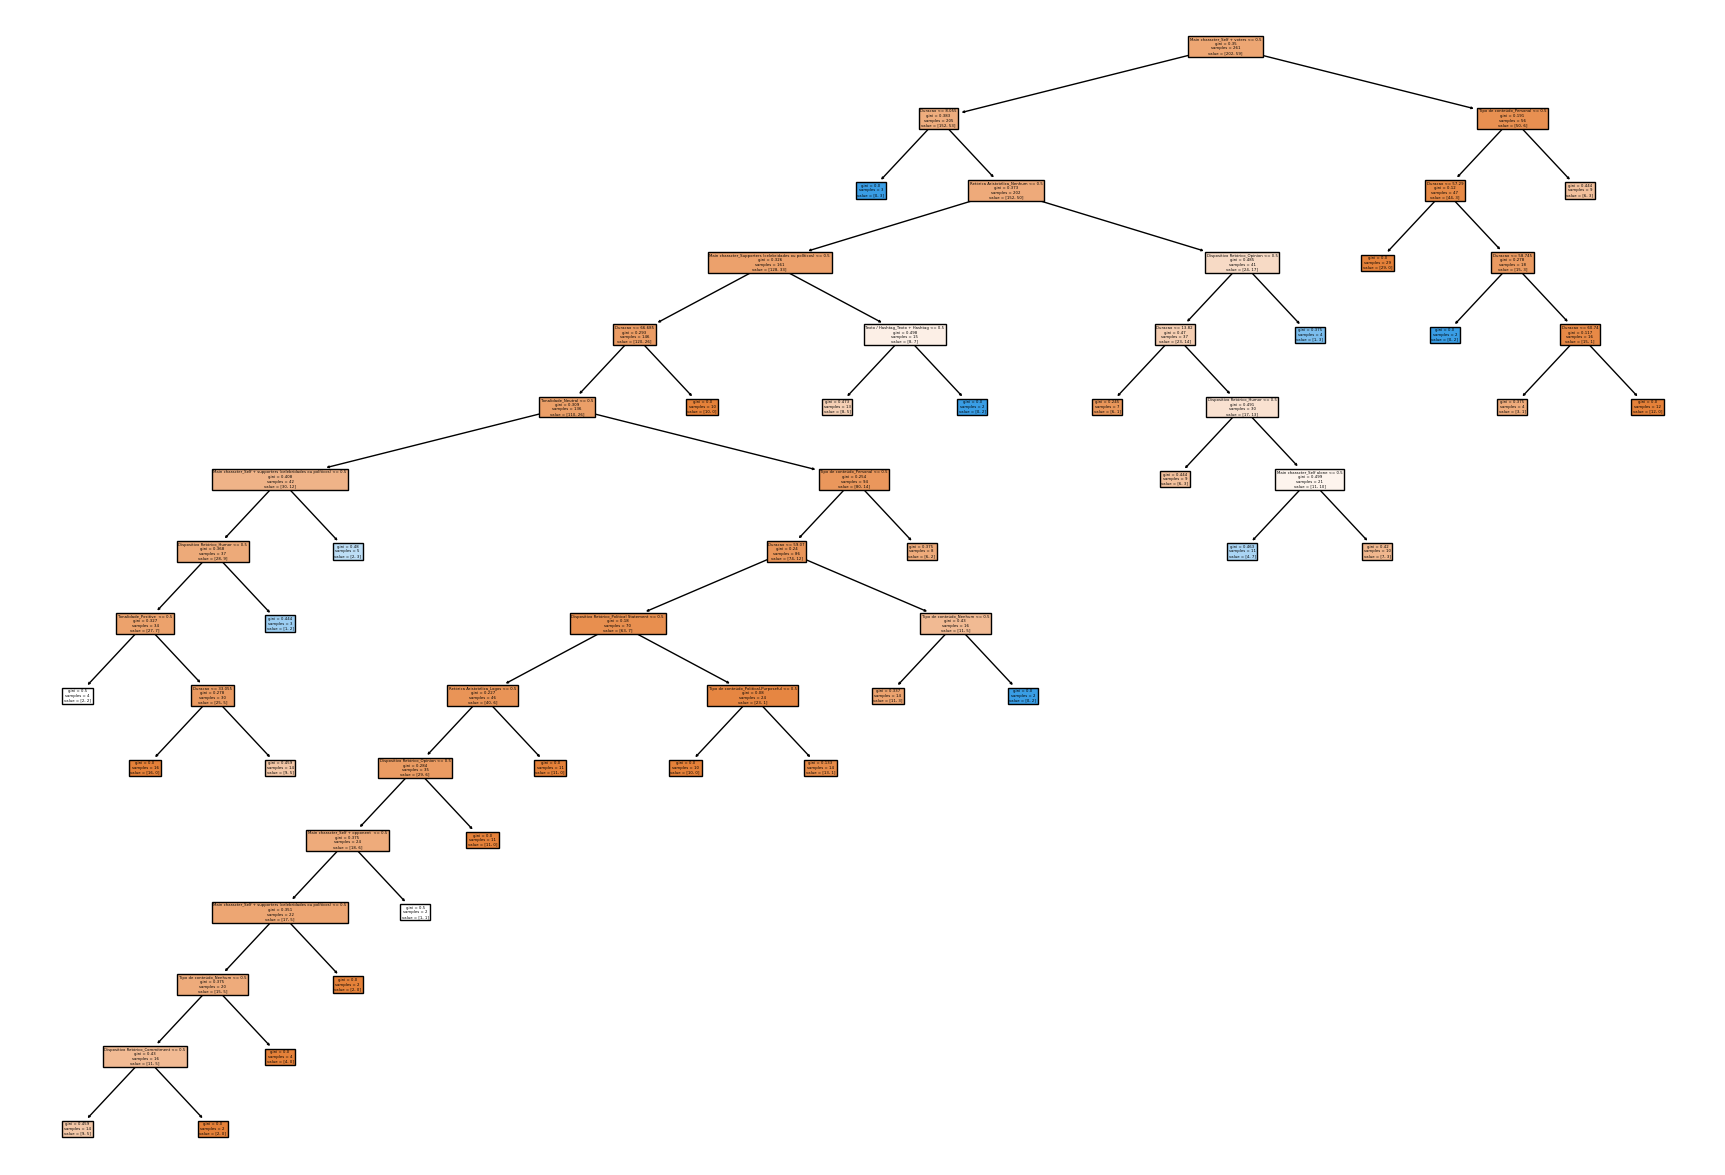

In [35]:
dec_tree = results['Decision Tree'][0]
fig = plt.figure(figsize=(22,15))
plot_tree(dec_tree, feature_names=list(dfx_grid.columns), filled=True);

In [36]:
rf = results['Random Forest'][0]
#pd.DataFrame({'features' : df_x.columns[2:], 'feature_importance' : rf.feature_importances_}).sort_values(by='feature_importance', ascending=False)

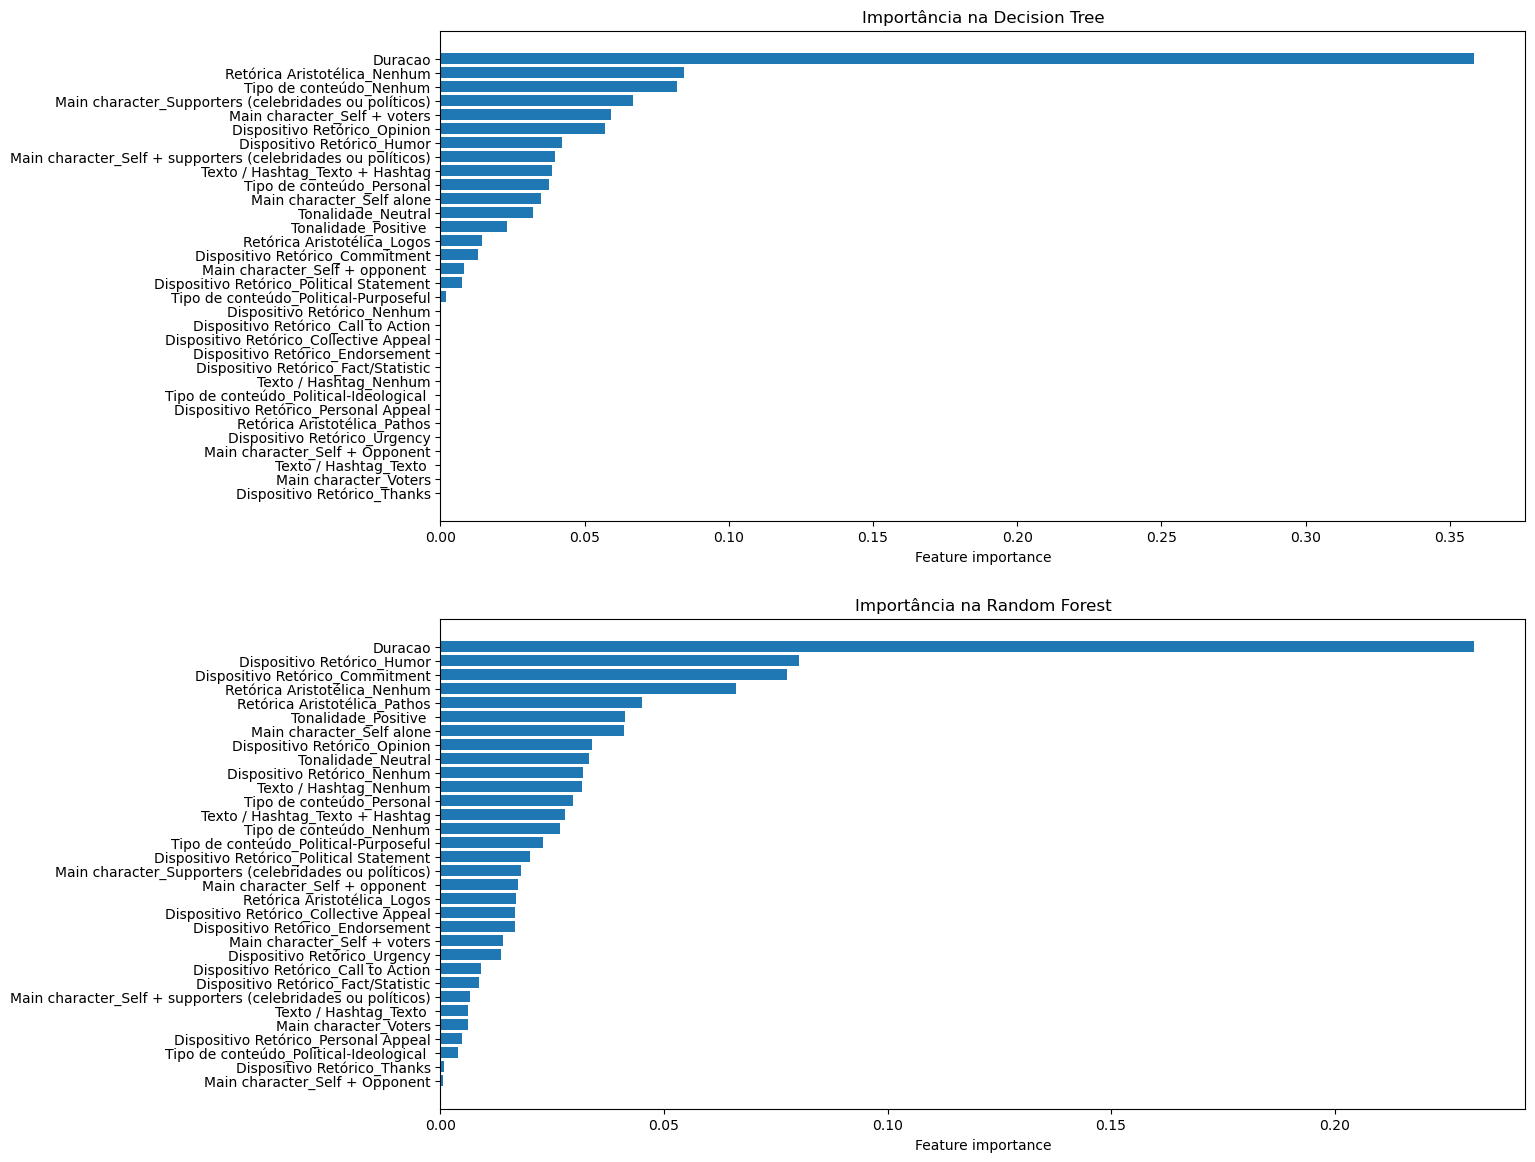

In [37]:
# plot the feature importances
fig, ax = plt.subplots(2, 1, figsize=(14, 14))
ax[0].set_title('Importância na Decision Tree')
plot_importance(dec_tree, feature_names=dfx_grid.columns, ax=ax[0])
ax[1].set_title('Importância na Random Forest')
plot_importance(rf, feature_names=dfx_grid.columns, ax=ax[1])
plt.show()

# 4 - Treinamento e Avaliação do Modelo Final

Recomendações para decidir quantos dados usar para treinar o modelo final:

1. É importante considerar o **equilíbrio entre *bias* e variância**. 
  - usar todos os dados disponíveis para treinar o modelo pode aumentar o **bias** (viés) do modelo;
  - usar apenas parte dos dados pode aumentar a **variância** do modelo. 

2. Em geral, é recomendável usar a **maior quantidade** de dados possível para treinar o modelo final, desde que isso não comprometa a capacidade do modelo de generalizar para novos dados. 

3. Pode ser útil usar a validação cruzada para avaliar o desempenho do modelo com diferentes quantidades de dados e escolher o modelo que tenha o melhor equilíbrio entre bias e variância. (Estamos fazendo isso na escolha do melhor modelo, antes).

In [38]:
# divide os dados em treino e teste, de forma estratificada (preservando a proporção entre as classes)
X_train, X_test, y_train, y_test = train_test_split(dfx, dfy, test_size=0.2, stratify=dfy, random_state=42)

In [39]:
#y_train.value_counts(normalize=True), y_test.value_counts(normalize=True)

In [40]:
best_model_grid.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('logreg', LogisticRegression(C=0.001, solver='liblinear'))])

In [41]:
y_predicted = best_model_grid.predict(X_test)

print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.84      0.78      0.81        41
           1       0.40      0.50      0.44        12

    accuracy                           0.72        53
   macro avg       0.62      0.64      0.63        53
weighted avg       0.74      0.72      0.73        53



In [42]:
print("Matrix de confusão (linhas - rótulos verdadeiros; colunas - rótulos previstos):")

matrix = confusion_matrix(y_test, y_predicted, normalize='true')

pd.DataFrame(matrix, columns=classes_str, index=classes_str) 

Matrix de confusão (linhas - rótulos verdadeiros; colunas - rótulos previstos):


,LOW,HIGH
LOW,0.780488,0.219512
HIGH,0.500000,0.500000


In [43]:
print("Matrix de confusão (linhas - rótulos verdadeiros; colunas - rótulos previstos):")

matrix = confusion_matrix(y_test, y_predicted)

pd.DataFrame(matrix, columns=classes_str, index=classes_str) 

Matrix de confusão (linhas - rótulos verdadeiros; colunas - rótulos previstos):


,LOW,HIGH
LOW,32,9
HIGH,6,6


### Alguns Resultados 


Modelo otimizado (no grid search) com a métrica **f1 score weighted** (recomendo usar esta):

- Melhores parâmetros (grid search)

```
BEST RESULTS:
-> model: Logist Regression
-> params: {'logreg__C': 0.001, 'logreg__penalty': 'l2', 'logreg__solver': 'liblinear', 'scaler': StandardScaler()}
-> grid-search score: -0.74 (f1 weighted)

```

- Resultados (modelo final, treinado apenas com dados de treinamento e avaliado com dados de teste separados)

```
              precision    recall  f1-score   support

           0       0.84      0.78      0.81        41
           1       0.40      0.50      0.44        12

    accuracy                           0.72        53
   macro avg       0.62      0.64      0.63        53
weighted avg       0.74      0.72      0.73        53
```

- Matriz de confusão
```
      LOW  HIGH
LOW   32    9
HIGH   6    6
```


---
Usando o **f1 score da classe positiva**:

- Melhores parâmetros

```
BEST RESULTS:
-> model: Logist Regression
-> params: {'logreg__C': 0.001, 'logreg__penalty': 'l2', 'logreg__solver': 'liblinear', 'scaler': StandardScaler()}
-> grid-search score: -0.44  (f1 score da classe 1)
```  

- Resultados

```
              precision    recall  f1-score   support

       False       0.84      0.78      0.81        41
        True       0.40      0.50      0.44        12

    accuracy                           0.72        53
   macro avg       0.62      0.64      0.63        53
weighted avg       0.74      0.72      0.73        53
```


- Matriz de confusão

```
      LOW  HIGH
LOW   32    9
HIGH   6    6
```

---
Usando o **precision** da classe positiva (é esquisito, mas deu bom resultado):

- Melhores parâmetros

```
BEST RESULTS:
-> model: Decision Tree
-> params: {'max_depth': 15, 'max_features': 'log2', 'min_samples_leaf': 5, 'min_samples_split': 15}
-> grid-search score: -0.56  (precision)
``` 

- Resultados

```
              precision    recall  f1-score   support

           0       0.83      0.95      0.89        41
           1       0.67      0.33      0.44        12

    accuracy                           0.81        53
   macro avg       0.75      0.64      0.67        53
weighted avg       0.79      0.81      0.79        53
```

- Matriz de confusão

```
      LOW  HIGH
LOW   39    2
HIGH   8    4

```